# Starting with DReAMy: encoding, reduction and visualisation

In this notebook, we will start using DReAMy and its basic functionalities. That is, downloading some data, collecting contextualised embeddings for dream reports, reducing the embeddings space, and searching for significant patterns in the reduced space. 

In [1]:
! pip install dreamy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import dreamy

Let's start by getting some reports. You can start by downloading a collection of dream reports scraped from the DreamBank database, freely available from DReAMy's hugging face datasets! 

DReAMy has direct access to two datasets. A smaller English-only (~ 20k), and a larger and multilingual one (En/De, ~ 30k). We will start with the English-Only one, as it has descriptive variables (such as gender and year). 

In [3]:
language   = "english" # choose between english/multi
dream_bank = dreamy.get_HF_DreamBank(as_dataframe=True, language=language)

dream_bank["sight"] = [
    "impaired" if "blind" in series_id else "normal" for series_id in dream_bank["series"]
]

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dream_bank.sample(2)

,series,description,dreams,gender,year,sight
7288,norms-f,Hall/VdC Norms: Female,I dreamt that I was sitting in Kulas with my f...,female,1940s-1950s,normal
4668,melvin,Melvin (Melora's husband),The dream centered around an unusual building....,male,1962,normal


As you can see, the (En-Only) file, downloaded directly as a pandas DataFrame, with five columns:
- series: which DreamBank's collection the report belongs to.
- description: a brief description of each series.
- dreams: the dream-reports.
- gender: the gender of the participant(s).
- year: the year-span of the series.

Let's now sample a small set of dreams. If you have a more powerful machine (or you are working on Colab), you can increase the number of reports. Note that the whole dataset contains ~ 20k reports.

In [5]:
set(dream_bank["series"])

{'alta',
 'angie',
 'arlie',
 'b',
 'b-baseline',
 'b2',
 'bay_area_girls_456',
 'bay_area_girls_789',
 'bea1',
 'bea2',
 'blind-f',
 'blind-m',
 'bosnak',
 'chris',
 'chuck',
 'dahlia',
 'david',
 'dorothea',
 'ed',
 'edna',
 'elizabeth',
 'emma',
 'emmas_husband',
 'esther',
 'hall_female',
 'jasmine1',
 'jasmine2',
 'jasmine3',
 'jasmine4',
 'jeff',
 'joan',
 'kenneth',
 'lawrence',
 'mack',
 'madeline1-hs',
 'madeline2-dorms',
 'madeline3-offcampus',
 'madeline4-postgrad',
 'mark',
 'melissa',
 'melora',
 'melvin',
 'merri',
 'miami-home',
 'miami-lab',
 'midwest_teens-f',
 'midwest_teens-m',
 'nancy',
 'natural_scientist',
 'norman',
 'norms-f',
 'norms-m',
 'pegasus',
 'peru-f',
 'peru-m',
 'phil1',
 'phil2',
 'phil3',
 'physiologist',
 'ringo',
 'samantha',
 'seventh_graders',
 'toby',
 'tom',
 'ucsc_women',
 'vickie',
 'vietnam_vet',
 'wedding',
 'west_coast_teens'}

In [6]:
n_samples = 20
dream_sample = dream_bank.sample(n_samples).reset_index(drop=True)

Now, we have to extract the reports as a list. Then we can easily use the `get_encodings` method to extract the contextualised encodings. The encodings are the `[CLS]` token of the LLM of choice. At the moment, you can choose between four LLMS, a combination of small/large English-only/multilingual (BERT / XLM-R).

In [7]:
model_size = "small"   # or large
model_lang = "english" # or multi, for multilingual
device     = "cuda"    # "cpu" for loca/cpu, "cuda" for GPUs

In [8]:
dream_list       = dream_sample["dreams"].tolist()
report_encodings = dreamy.get_encodings(
    dream_list, 
    model_size=model_size,
    language=model_lang, 
    device=device,
)

Loading/Downloading model and tokenizer


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now that we have collected our embeddings for each report, we can call use dreamy to directly `reduce_space` the dimensionality of the reports' space. At the moment, dreamy offers two dimensionality reduction methods: `pca` and `t-sne`

In [9]:
X, Y = dreamy.reduce_space(report_encodings, method="pca")

After collecting the coordinates of the reduced space, we can update our `DataFrame`, to plot the obtained results.

In [10]:
dream_sample["DR_X"], dream_sample["DR_Y"] = X, Y

To visualise the space, we will use `seaborn`, since it well integrates with `Pandas`. We will start by plotting the 2-D space as a scatter plot, and use the different series as hue.

In [11]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

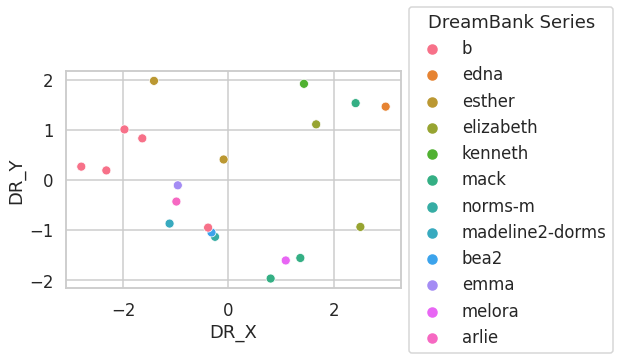

In [12]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="series",
)

g.legend(loc='center left', title="DreamBank Series", bbox_to_anchor=(1, 0.5))

No clear pattern can be identified, we will further use a K-Mean cluster to search for possible implicit clusters in the data. We can directly use dreamy's `get_KMeans` method.

In [13]:
n_clusters = 2

clusters_labels = dreamy.get_KMeans(report_encodings, n_clusters)
dream_sample["KM_clusters"] = clusters_labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


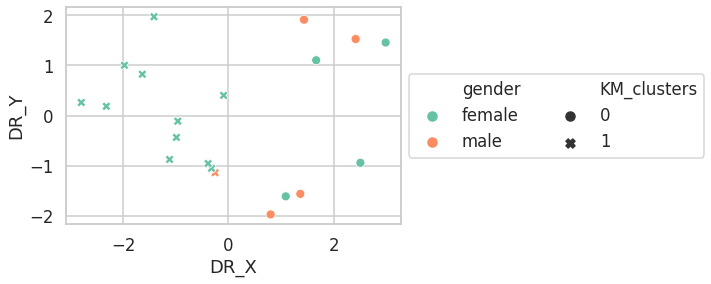

In [14]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="gender",
    palette="Set2",
    style="KM_clusters",
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

The two clusters don't seem to correlate/represent the gender of each participant. Lat's try with series!

In [17]:
n_series = len(set(dream_sample["series"]))

series_labels = dreamy.get_KMeans(report_encodings, n_series)
dream_sample["KM_series"] = series_labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


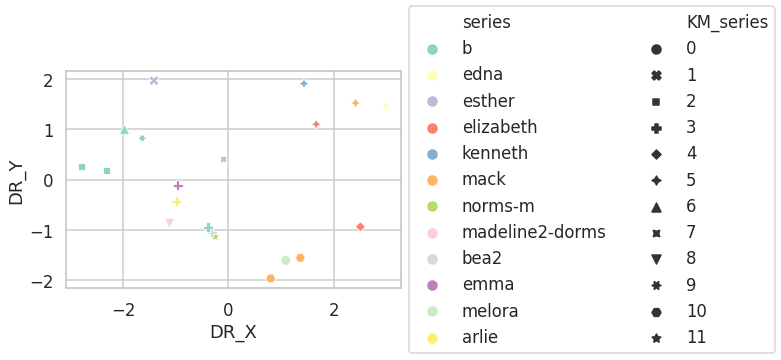

In [19]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="series",
    style="KM_series",
    palette="Set3",
    s=100,
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

That does not seem to be it either. This is not really a bad thing. It suggests that the model is not using gender or series to distinguish the (compressed) semantic representations of the reports. A sentiment-based analysis might reveal more about what the model is actually focusing on. For such analysis, please refer to the specific tutorial on dreamy git page!